1. $$y(x)=\sum_{n=1}^Na_nt_nk(x,x_n)+b$$
2. $$ \text{if }y1\neq y2 \text{ then } L=max(0,a_2^{old}),H=min(C,C+a_2^{old}-a_1^{old})$$
3. $$ \text{if }y1=y2\text{ then } L=max(0,a_2^{old}+a_1^{old}-C),H=min(C,a_2^{old}+a_1^{old})$$
4. $$\eta = K_{11}+K_{22}-2K_{12}$$
5. $$a_2^{new,unc}=a_2^{old}+\frac{y_2(E_1-E_2)}{\eta}$$
6. $$a_1^{new}=a_1^{old}+y_1y_2(a_2^{old}-a_2^{new})$$
7. $$b_1^{new}=-E_1-y_1K_{11}(a_1^{new}-a_1^{old}-y_2K_{21}(a_2^{new}-a_2^{old})+b^{old}$$
8. $$b_2^{new}=-E_2-y_1K_{11}(a_1^{new}-a_1^{old}-y_2K_{22}(a_2^{new}-a_2^{old})+b^{old}$$

In [10]:
import numpy as np
#SMO算法中的辅助函数
def loadDataSet(fileName):
    dataMat = [];labelMat=[]
    fr = open(fileName)
    for line in fr.readlines():
        lineArr=line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    return j
def clipAlpha(aj,H,L):
    if aj>H:
        aj = H
    if L>aj:
        aj = L
    return aj

In [16]:


#dataMatIn-训练样本 classLabels-每个训练样本对应的标签 C-an的上限 toler-误差门限 maxlter-迭代次数
def smoSimple(dataMatIn,classLabels,C,toler,maxlter):
    dataMat = np.mat(dataMatIn);
    labelMat = np.mat(classLabels).transpose()
    b = 0;m,n = np.shape(dataMat) # m个样本n个特征
    alphas = np.mat(np.zeros((m,1)))
    my_iter = 0
    while(my_iter<maxlter):
        alphaPairsChanged = 0
        for i in range(m): # 顺序选择第一个样本点
            fXi = float(np.multiply(alphas,labelMat).T*(dataMat*dataMat[i,:].T)) + b #①
            Ei = fXi - float(labelMat[i])
            # 检查是否破坏了KKT条件,两个方向检查，确保an不会突破上下限
            if((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i]>0)):
                j = selectJrand(i,m) #随机选择另一个样本点
                fXj = float(np.multiply(alphas,labelMat).T*(dataMat*dataMat[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                oldI = alphas[i].copy();oldJ = alphas[j].copy();
                if(labelMat[i]!=labelMat[j]): #2
                    L=max(0,alphas[j]-alphas[i])
                    H=min(C,C+alphas[j]-alphas[i])
                else:#3
                    L=max(0,alphas[j]+alphas[i]-C)
                    H=min(C,alphas[j]+alphas[i])
                if L==H:print('L==H');continue
                    #这里其实算的是-eta
                eta = 2.0*dataMat[i,:]*dataMat[j,:].T-dataMat[i,:]*dataMat[i,:].T-dataMat[j,:]*dataMat[j,:].T#4
                if eta>=0:print('eta>0');continue
                alphas[j] -= labelMat[j]*(Ei-Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if(abs(alphas[j]-oldJ)<0.00001):print('j not moving enough');continue
                alphas[i] += labelMat[j] * labelMat[i]*(oldJ-alphas[j])#6
                b1=b-Ei-labelMat[i]*(alphas[i]-oldI)*dataMat[i,:]*dataMat[i,:].T-\
                labelMat[j]*(alphas[j]-oldJ)*dataMat[i,:]*dataMat[j,:].T#7
                b2=b-Ej-labelMat[i]*(alphas[i]-oldI)*dataMat[j,:]*dataMat[j,:].T-\
                labelMat[j]*(alphas[j]-oldJ)*dataMat[j,:]*dataMat[j,:].T#8
                #如果都满足条件则 b1_new=b2_new，反之选择他们的中点作为b_new
                if(0<alphas[i]) and (C>alphas[i]):b=b1
                elif (0<alphas[j]) and (C>alphas[j]):b=b2
                else :b=(b1+b2)/2.0
                alphaPairsChanged +=1
                print('iter: {} i: {},pairs changed {}'.format(my_iter,i,alphaPairsChanged))
            if(alphaPairsChanged == 0): my_iter+=1
            else: iter = 0
            print('iteration number: {}'.format(my_iter))
        return b,alphas
            
        
    

In [ ]:
dataArr,labelArr=loadDataSet('testSet.txt')
labelArr

In [ ]:
b,alphas=smoSimple(dataArr,labelArr,0.6,0.001,40)

In [83]:
b

matrix([[-2.71798535]])

In [25]:
alphas[alphas>0]

matrix([[0.00465525, 0.03604421, 0.06523572, 0.06523572, 0.00058305,
         0.08218457, 0.03604421, 0.08218457, 0.00058305, 0.00465525]])

In [108]:
x_support=[];y_support=[]
for i in range(100):
    if alphas[i]>0.0:
        print(dataArr[i],labelArr[i])
        x_support.append(dataArr[i][0])
        y_support.append(dataArr[i][1])

[3.542485, 1.977398] -1.0
[8.127113, 1.274372] 1.0
[7.108772, -0.986906] 1.0
[2.123252, -0.783563] -1.0
[0.887835, -2.797792] -1.0
[7.286357, 0.251077] 1.0
[2.450939, 0.744967] -1.0
[6.960661, -0.245353] 1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0
[6.016004, -3.753712] 1.0
[-0.236713, -5.766721] -1.0
[3.107511, 0.758367] -1.0


In [40]:
x=[dataArr[i][0] for i in range(len(dataArr))]
y=[dataArr[i][1] for i in range(len(dataArr))]
x1=[];x2=[];y1=[];y2=[]
for i in range(len(dataArr)):
    if labelArr[i]==1.0:
        x1.append(x[i])
        y1.append(y[i])
    else: 
        x2.append(x[i])
        y2.append(y[i])

In [43]:
import matplotlib.pyplot as plt

In [38]:
def calcWs(alphas,dataArr,classLabels):
    x=np.mat(dataArr);labelmat=np.mat(classLabels).transpose()
    m,n=np.shape(x)
    w=np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelmat[i],x[i,:].T)
    return w
    

<IPython.core.display.Javascript object>


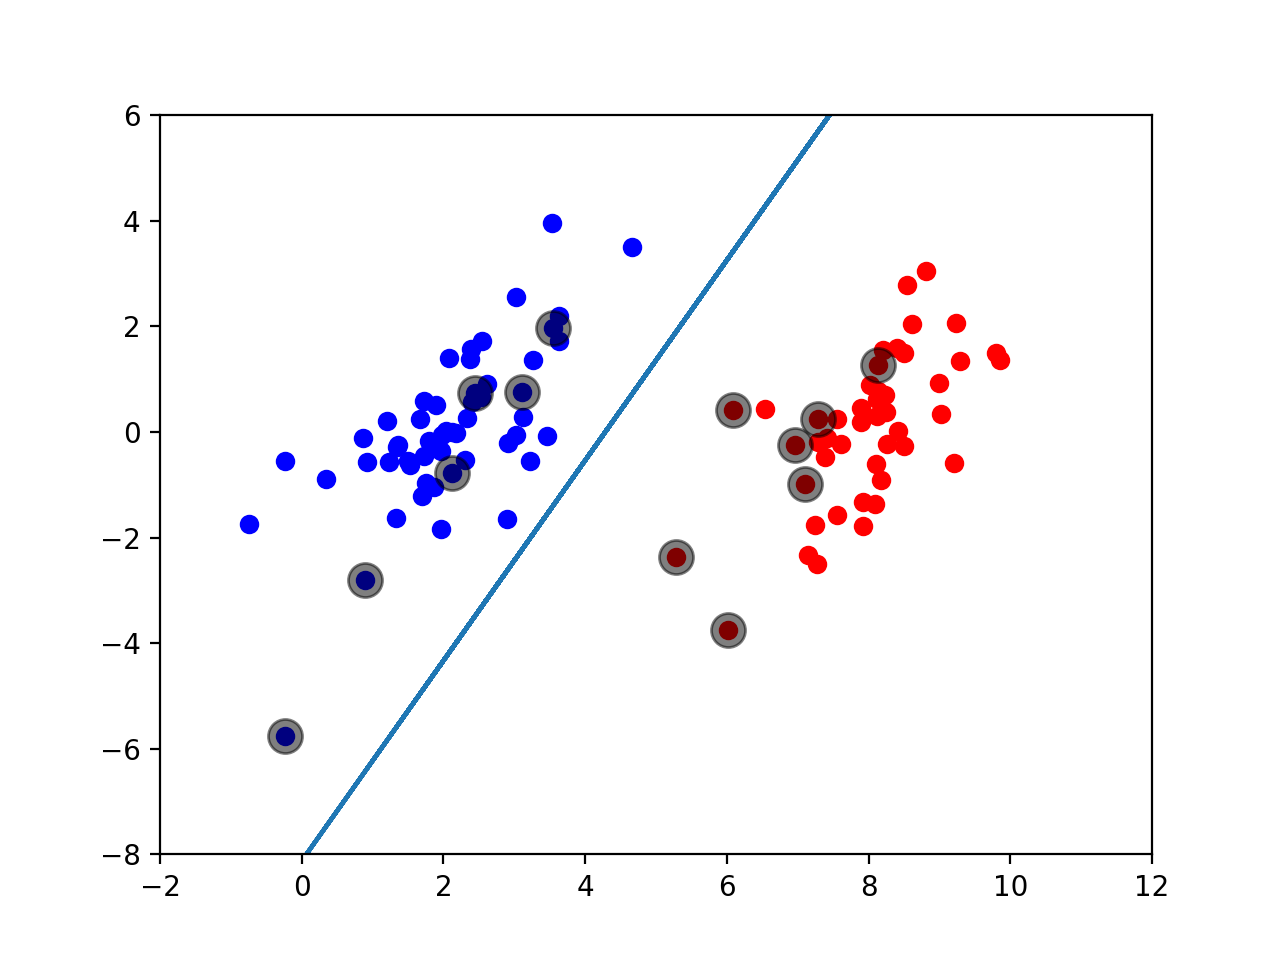

In [109]:
%matplotlib notebook
plt.axis([-2,12,-8,6])
plt.scatter(x2,y2,c='b')
plt.scatter(x1,y1,c='r')
plt.scatter(x_support, y_support,s=150,c='black',marker='o',alpha=0.5)
plt.plot(x,line_x2)

In [30]:
#完整的SMO支持函数
class optStruct:
    def __init__(self,dataMatIn,classLabels,C,toler,KTup):
        self.x=dataMatIn
        self.c=C
        self.labelMat=classLabels
        self.tol=toler
        self.m=np.shape(dataMatIn)[0]
        self.alphas=np.mat(np.zeros((self.m,1)))
        self.b=0
        self.eCache=np.mat(np.zeros((self.m,2)))
        self.K=np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i]=kernelTrans(self.x,self.x[i,:],KTup)
        
def calcEk(oS,k):
    fxk=float(np.multiply(oS.alphas,oS.labelMat).T*(oS.x*oS.x[k,:].T))+oS.b
    Ek=fxk-float(oS.labelMat[k])
    return Ek
def selectJ(i,oS,Ei):
    maxK=-1;maxDeltaE=0;Ej=0
    oS.eCache[i]=[1,Ei]
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0]
    if(len(validEcacheList))>1:
        for k in validEcacheList:
            if k==i:continue
            Ek=calcEk(oS,k)
            deltaE=abs(Ei-Ek)
            if(deltaE>maxDeltaE):
                maxK=k;maxDeltaE=deltaE;Ej=Ek
        return maxK,Ej
    else:
        j=selectJrand(i,oS.m)
        Ej=calcEk(oS,j)
    return j,Ej
def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.eCache[k]=[1,Ek]
def kernelTrans(x,A,ktup):
    m,n=np.shape(x)
    k=np.mat(np.zeros((m,1)))
    if ktup[0]=='lin':k=x*A.T #线性核函数,我们还是用线性核函数 f(x)=x
    elif ktup[0]=='rbf':
        for j in range(m):
            deltaRow = x[j,:]-A
            k[j]=deltaRow*deltaRow.T
        k=np.exp(k/-1*ktup[1]**2)
    else:raise NameError('Houston we have a problem--Thatkernel is not recognized')
    return k

In [32]:
def innerL(i,oS):
    Ei=calcEk(oS,i)
    if((oS.labelMat[i]*Ei<-oS.tol) and (oS.alphas[i]<oS.c)) or ((oS.labelMat[i]*Ei>oS.tol) and oS.alphas[i]>0):
        j,Ej=selectJ(i,oS,Ei)#与selectJrand的方法不同
        old_i=oS.alphas[i].copy();old_j=oS.alphas[j].copy()
        if(oS.labelMat[i]!=oS.labelMat[j]):
            L=max(0,oS.alphas[j]-oS.alphas[i])
            H=min(oS.c,oS.c+oS.alphas[j]-oS.alphas[i])
        else:
            L=max(0,oS.alphas[j]+oS.alphas[i]-oS.c)
            H=min(oS.c,oS.c+oS.alphas[j]+oS.alphas[i])
        if L==H:print('L==H');return 0
        eta=2.0*oS.K[i,j]-oS.K[i,i]-oS.K[j,j]#根据核函数计算eta
        if(eta>=0):print('eta>=0');return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei-Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if(abs(oS.alphas[j]-old_j)<0.00001):print('j not moving enough');return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(old_j-oS.alphas[j])
        updateEk(oS,i)
        b1=oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-old_i)*oS.K[i,i]-oS.labelMat[j]*(oS.alphas[j]-old_j)*oS.K[i,j]
        b2=oS.b-Ei-oS.labelMat[i]*(oS.alphas[i]-old_i)*oS.K[i,j]-oS.labelMat[j]*(oS.alphas[j]-old_j)*oS.K[j,j]
        if(0<oS.alphas[i]) and (oS.c>oS.alphas[i]):oS.b=b1
        elif(0<oS.alphas[j]) and (oS.c>oS.alphas[j]):oS.b=b2
        else:oS.b=(b1+b2)/2.0
        return 1
    else: return 0        

In [8]:
def smoP(dataMatIn,classLabels,C,toler,maxIter,Ktup=('lin',0)):
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler,Ktup)
    myiter=0
    entireSet = True;changeflag=0
    while(myiter<maxIter) and ((changeflag > 0) or (entireSet)):
        changeflag=0
        if entireSet:
            for i in range(oS.m):
                changeflag+=innerL(i,oS)
                print("fullSet,iter:{} i:{},pairs changed {}".format(myiter,i,changeflag))
            myiter+=1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A>0)*(oS.alphas.A<C))[0]
            for i in nonBoundIs:
                changeflag+=innerL(i,oS)
                print('non-bound,iter:{} i:{},pairs changed {}'.format(myiter,i,changeflag))
            myiter+=1
        if entireSet:entireSet=False
        elif(changeflag==0):entireSet = True
        print("iteration number {}".format(myiter))
    return oS.b,oS.alphas
            

In [ ]:
b,alpha=smoP(dataArr,labelArr,0.6,0.001,40)

In [53]:
def plotAns(b,alphas):
    x_support=[];y_support=[]
    for i in range(100):
        if alphas[i]>0.0:
            x_support.append(dataArr[i][0])
            y_support.append(dataArr[i][1])
    ws = calcWs(alphas,dataArr,labelArr)
    x=[dataArr[i][0] for i in range(len(dataArr))]
    y=[dataArr[i][1] for i in range(len(dataArr))]
    x1=[];x2=[];y1=[];y2=[]
    for i in range(len(dataArr)):
        if labelArr[i]==1.0:
            x1.append(x[i])
            y1.append(y[i])
        else: 
            x2.append(x[i])
            y2.append(y[i])
    line_x2=[]
    for i in range(len(x)):
        line_x2.append(float((-ws[0]/ws[1])*x[i]-b/ws[1]))
    %matplotlib notebook
    plt.axis([-2,12,-8,6])
    plt.scatter(x2,y2,c='b')
    plt.scatter(x1,y1,c='r')
    plt.scatter(x_support, y_support,s=150,c='black',marker='o',alpha=0.5)
    plt.plot(x,line_x2)

<IPython.core.display.Javascript object>


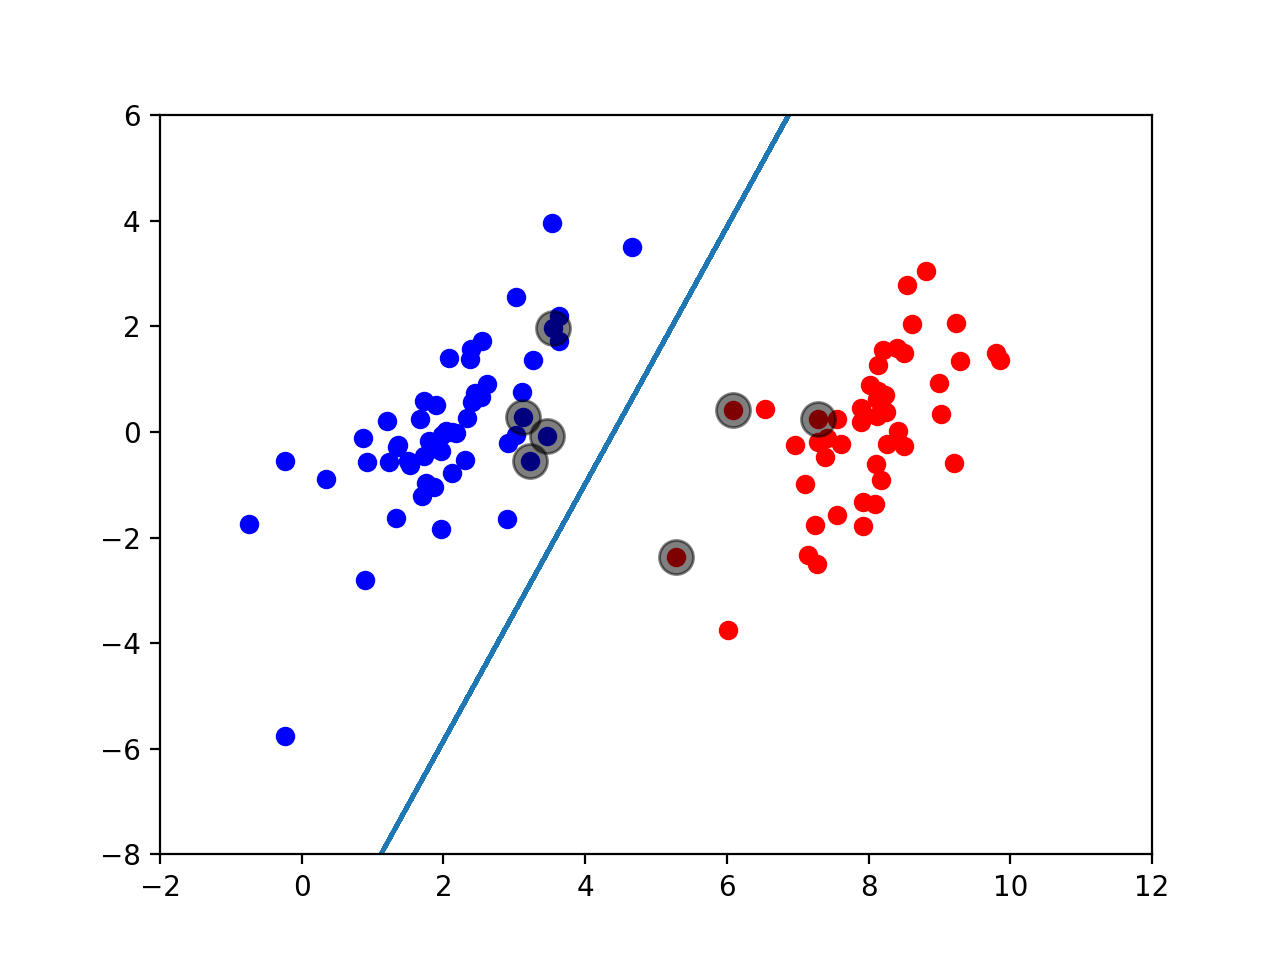

In [54]:
plotAns(b,alpha)

In [86]:
def img2vector(filename):
    returnVect=np.zeros((1,1024))
    fr=open(filename)
    for i in range(32):
        lineStr=fr.readline()
        for j in range(32):
            returnVect[0,32*i+j]=int(lineStr[j])
    return returnVect
def loadImages(dirName):
    from os import listdir
    hwlabel=[]
    trainingFileList=listdir(dirName)
    m=len(trainingFileList)
    trainingMat=np.zeros((m,1024))
    for i in range(m):
        fileNameStr=trainingFileList[i]
        fileStr=fileNameStr.split('.')[0]
        classNumStr=int(fileStr.split('_')[0])
        print("fileName={} classNum={}".format(fileStr,classNumStr))
        if classNumStr == 9:hwlabel.append(-1)
        else: hwlabel.append(1)
        trainingMat[i,:]= img2vector('%s%s' % (dirName,fileNameStr))
    return trainingMat,hwlabel
def testDigits(ktup=('rbf',10)):
    dataArr,labelArr=loadImages('digits/trainingDigits/')
    b,alphas=smoP(dataArr,labelArr,200,0.0001,40,ktup)
    print(b)
    dataMat=np.mat(dataArr);labelMat=np.mat(labelArr).transpose()
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=dataMat[svInd]
    labelSV=labelMat[svInd]
    print("支持向量数量为:{}".format(np.shape(sVs)[0]))
    m,n=np.shape(dataMat)
    errorCount=0
    for i in range(m):  
        kernelEval=kernelTrans(sVs,dataMat[i,:],ktup)
        predict=kernelEval.T*np.multiply(labelSV,alphas[svInd])+b
        print(predict)
        if np.sign(predict) != np.sign(labelArr[i]):errorCount += 1
    print('训练集的错误率为:{}'.format(float(errorCount)/m))
    dataArr,labelArr=loadImages('digits/testDigits/')
    errorCount=0
    dataMat=np.mat(dataArr);labelMat=np.mat(labelArr).transpose()
    m,n=np.shape(dataMat)
    for i in range(m):
        kernelEval=kernelTrans(sVs,dataMat[i,:],ktup)
        predict=kernelEval.T*np.multiply(labelSV,alphas[svInd])+b
        if np.sign(predict) != np.sign(labelArr[i]):errorCount += 1
    print('测试集的错误率为:{}'.format(float(errorCount)/m))

In [89]:
testDigits()


fileName=9_113 classNum=9
fileName=9_76 classNum=9
fileName=9_107 classNum=9
fileName=9_62 classNum=9
fileName=9_89 classNum=9
fileName=1_101 classNum=1
fileName=1_115 classNum=1
fileName=1_129 classNum=1
fileName=9_2 classNum=9
fileName=1_12 classNum=1
fileName=1_13 classNum=1
fileName=9_3 classNum=9
fileName=1_128 classNum=1
fileName=1_114 classNum=1
fileName=1_100 classNum=1
fileName=9_88 classNum=9
fileName=9_63 classNum=9
fileName=9_106 classNum=9
fileName=9_77 classNum=9
fileName=9_112 classNum=9
fileName=1_8 classNum=1
fileName=9_104 classNum=9
fileName=9_61 classNum=9
fileName=9_110 classNum=9
fileName=9_75 classNum=9
fileName=9_138 classNum=9
fileName=9_49 classNum=9
fileName=1_116 classNum=1
fileName=1_102 classNum=1
fileName=1_39 classNum=1
fileName=1_11 classNum=1
fileName=9_1 classNum=9
fileName=9_0 classNum=9
fileName=1_10 classNum=1
fileName=1_38 classNum=1
fileName=1_103 classNum=1
fileName=1_117 classNum=1
fileName=9_48 classNum=9
fileName=9_139 classNum=9
fileName=9_7

j not moving enough
fullSet,iter:0 i:0,pairs changed 0
fullSet,iter:0 i:1,pairs changed 1
fullSet,iter:0 i:2,pairs changed 1
fullSet,iter:0 i:3,pairs changed 1
fullSet,iter:0 i:4,pairs changed 1
fullSet,iter:0 i:5,pairs changed 1
fullSet,iter:0 i:6,pairs changed 1
fullSet,iter:0 i:7,pairs changed 1
fullSet,iter:0 i:8,pairs changed 2
j not moving enough
fullSet,iter:0 i:9,pairs changed 2
j not moving enough
fullSet,iter:0 i:10,pairs changed 2
fullSet,iter:0 i:11,pairs changed 2
j not moving enough
fullSet,iter:0 i:12,pairs changed 2
j not moving enough
fullSet,iter:0 i:13,pairs changed 2
j not moving enough
fullSet,iter:0 i:14,pairs changed 2
fullSet,iter:0 i:15,pairs changed 2
fullSet,iter:0 i:16,pairs changed 2
fullSet,iter:0 i:17,pairs changed 2
fullSet,iter:0 i:18,pairs changed 2
fullSet,iter:0 i:19,pairs changed 2
j not moving enough
fullSet,iter:0 i:20,pairs changed 2
fullSet,iter:0 i:21,pairs changed 2
fullSet,iter:0 i:22,pairs changed 2
fullSet,iter:0 i:23,pairs changed 2
fullSe

/var/folders/c_/twtz2wws71xb3vg20sfnfdww0000gn/T/ipykernel_3937/2160594792.py:22: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  oS.eCache[i]=[1,Ei]
/var/folders/c_/twtz2wws71xb3vg20sfnfdww0000gn/T/ipykernel_3937/2160594792.py:38: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  oS.eCache[k]=[1,Ek]


j not moving enough
fullSet,iter:0 i:240,pairs changed 19
fullSet,iter:0 i:241,pairs changed 19
fullSet,iter:0 i:242,pairs changed 19
fullSet,iter:0 i:243,pairs changed 20
fullSet,iter:0 i:244,pairs changed 20
fullSet,iter:0 i:245,pairs changed 20
fullSet,iter:0 i:246,pairs changed 20
fullSet,iter:0 i:247,pairs changed 20
fullSet,iter:0 i:248,pairs changed 20
fullSet,iter:0 i:249,pairs changed 20
fullSet,iter:0 i:250,pairs changed 20
fullSet,iter:0 i:251,pairs changed 20
fullSet,iter:0 i:252,pairs changed 20
fullSet,iter:0 i:253,pairs changed 20
fullSet,iter:0 i:254,pairs changed 20
fullSet,iter:0 i:255,pairs changed 20
fullSet,iter:0 i:256,pairs changed 20
fullSet,iter:0 i:257,pairs changed 20
j not moving enough
fullSet,iter:0 i:258,pairs changed 20
fullSet,iter:0 i:259,pairs changed 21
fullSet,iter:0 i:260,pairs changed 21
fullSet,iter:0 i:261,pairs changed 22
fullSet,iter:0 i:262,pairs changed 22
fullSet,iter:0 i:263,pairs changed 22
fullSet,iter:0 i:264,pairs changed 22
fullSet,it

j not moving enough
fullSet,iter:3 i:80,pairs changed 11
fullSet,iter:3 i:81,pairs changed 12
fullSet,iter:3 i:82,pairs changed 12
fullSet,iter:3 i:83,pairs changed 12
fullSet,iter:3 i:84,pairs changed 12
fullSet,iter:3 i:85,pairs changed 12
fullSet,iter:3 i:86,pairs changed 12
fullSet,iter:3 i:87,pairs changed 12
fullSet,iter:3 i:88,pairs changed 12
fullSet,iter:3 i:89,pairs changed 12
fullSet,iter:3 i:90,pairs changed 12
fullSet,iter:3 i:91,pairs changed 13
fullSet,iter:3 i:92,pairs changed 13
fullSet,iter:3 i:93,pairs changed 13
fullSet,iter:3 i:94,pairs changed 13
fullSet,iter:3 i:95,pairs changed 13
fullSet,iter:3 i:96,pairs changed 13
fullSet,iter:3 i:97,pairs changed 13
fullSet,iter:3 i:98,pairs changed 13
fullSet,iter:3 i:99,pairs changed 13
fullSet,iter:3 i:100,pairs changed 13
fullSet,iter:3 i:101,pairs changed 13
fullSet,iter:3 i:102,pairs changed 13
fullSet,iter:3 i:103,pairs changed 13
j not moving enough
fullSet,iter:3 i:104,pairs changed 13
j not moving enough
fullSet,it

j not moving enough
fullSet,iter:3 i:307,pairs changed 29
j not moving enough
fullSet,iter:3 i:308,pairs changed 29
j not moving enough
fullSet,iter:3 i:309,pairs changed 29
j not moving enough
fullSet,iter:3 i:310,pairs changed 29
j not moving enough
fullSet,iter:3 i:311,pairs changed 29
j not moving enough
fullSet,iter:3 i:312,pairs changed 29
j not moving enough
fullSet,iter:3 i:313,pairs changed 29
j not moving enough
fullSet,iter:3 i:314,pairs changed 29
fullSet,iter:3 i:315,pairs changed 29
fullSet,iter:3 i:316,pairs changed 29
fullSet,iter:3 i:317,pairs changed 29
fullSet,iter:3 i:318,pairs changed 29
fullSet,iter:3 i:319,pairs changed 29
fullSet,iter:3 i:320,pairs changed 29
j not moving enough
fullSet,iter:3 i:321,pairs changed 29
j not moving enough
fullSet,iter:3 i:322,pairs changed 29
fullSet,iter:3 i:323,pairs changed 29
fullSet,iter:3 i:324,pairs changed 29
fullSet,iter:3 i:325,pairs changed 29
fullSet,iter:3 i:326,pairs changed 29
fullSet,iter:3 i:327,pairs changed 29
fu

fullSet,iter:6 i:129,pairs changed 16
fullSet,iter:6 i:130,pairs changed 17
fullSet,iter:6 i:131,pairs changed 17
fullSet,iter:6 i:132,pairs changed 17
j not moving enough
fullSet,iter:6 i:133,pairs changed 17
j not moving enough
fullSet,iter:6 i:134,pairs changed 17
j not moving enough
fullSet,iter:6 i:135,pairs changed 17
fullSet,iter:6 i:136,pairs changed 18
fullSet,iter:6 i:137,pairs changed 18
j not moving enough
fullSet,iter:6 i:138,pairs changed 18
fullSet,iter:6 i:139,pairs changed 19
fullSet,iter:6 i:140,pairs changed 19
fullSet,iter:6 i:141,pairs changed 19
fullSet,iter:6 i:142,pairs changed 19
fullSet,iter:6 i:143,pairs changed 19
fullSet,iter:6 i:144,pairs changed 19
fullSet,iter:6 i:145,pairs changed 19
j not moving enough
fullSet,iter:6 i:146,pairs changed 19
fullSet,iter:6 i:147,pairs changed 19
fullSet,iter:6 i:148,pairs changed 20
fullSet,iter:6 i:149,pairs changed 20
fullSet,iter:6 i:150,pairs changed 21
fullSet,iter:6 i:151,pairs changed 22
fullSet,iter:6 i:152,pairs

j not moving enough
fullSet,iter:6 i:313,pairs changed 28
j not moving enough
fullSet,iter:6 i:314,pairs changed 28
fullSet,iter:6 i:315,pairs changed 28
fullSet,iter:6 i:316,pairs changed 28
fullSet,iter:6 i:317,pairs changed 28
fullSet,iter:6 i:318,pairs changed 28
fullSet,iter:6 i:319,pairs changed 28
fullSet,iter:6 i:320,pairs changed 28
j not moving enough
fullSet,iter:6 i:321,pairs changed 28
j not moving enough
fullSet,iter:6 i:322,pairs changed 28
fullSet,iter:6 i:323,pairs changed 28
fullSet,iter:6 i:324,pairs changed 28
fullSet,iter:6 i:325,pairs changed 28
fullSet,iter:6 i:326,pairs changed 28
fullSet,iter:6 i:327,pairs changed 28
fullSet,iter:6 i:328,pairs changed 28
fullSet,iter:6 i:329,pairs changed 28
fullSet,iter:6 i:330,pairs changed 28
j not moving enough
fullSet,iter:6 i:331,pairs changed 28
fullSet,iter:6 i:332,pairs changed 28
fullSet,iter:6 i:333,pairs changed 28
j not moving enough
fullSet,iter:6 i:334,pairs changed 28
j not moving enough
fullSet,iter:6 i:335,pai

j not moving enough
fullSet,iter:9 i:135,pairs changed 17
fullSet,iter:9 i:136,pairs changed 18
fullSet,iter:9 i:137,pairs changed 18
j not moving enough
fullSet,iter:9 i:138,pairs changed 18
fullSet,iter:9 i:139,pairs changed 19
fullSet,iter:9 i:140,pairs changed 19
fullSet,iter:9 i:141,pairs changed 19
fullSet,iter:9 i:142,pairs changed 19
fullSet,iter:9 i:143,pairs changed 19
fullSet,iter:9 i:144,pairs changed 19
fullSet,iter:9 i:145,pairs changed 19
j not moving enough
fullSet,iter:9 i:146,pairs changed 19
fullSet,iter:9 i:147,pairs changed 19
fullSet,iter:9 i:148,pairs changed 20
fullSet,iter:9 i:149,pairs changed 20
fullSet,iter:9 i:150,pairs changed 21
fullSet,iter:9 i:151,pairs changed 22
fullSet,iter:9 i:152,pairs changed 22
fullSet,iter:9 i:153,pairs changed 22
fullSet,iter:9 i:154,pairs changed 22
j not moving enough
fullSet,iter:9 i:155,pairs changed 22
fullSet,iter:9 i:156,pairs changed 23
fullSet,iter:9 i:157,pairs changed 23
fullSet,iter:9 i:158,pairs changed 23
fullSet,

j not moving enough
fullSet,iter:9 i:331,pairs changed 28
fullSet,iter:9 i:332,pairs changed 28
fullSet,iter:9 i:333,pairs changed 28
j not moving enough
fullSet,iter:9 i:334,pairs changed 28
j not moving enough
fullSet,iter:9 i:335,pairs changed 28
j not moving enough
fullSet,iter:9 i:336,pairs changed 28
j not moving enough
fullSet,iter:9 i:337,pairs changed 28
j not moving enough
fullSet,iter:9 i:338,pairs changed 28
fullSet,iter:9 i:339,pairs changed 28
fullSet,iter:9 i:340,pairs changed 28
j not moving enough
fullSet,iter:9 i:341,pairs changed 28
j not moving enough
fullSet,iter:9 i:342,pairs changed 28
fullSet,iter:9 i:343,pairs changed 28
fullSet,iter:9 i:344,pairs changed 28
fullSet,iter:9 i:345,pairs changed 28
fullSet,iter:9 i:346,pairs changed 28
fullSet,iter:9 i:347,pairs changed 28
fullSet,iter:9 i:348,pairs changed 28
fullSet,iter:9 i:349,pairs changed 28
fullSet,iter:9 i:350,pairs changed 28
j not moving enough
fullSet,iter:9 i:351,pairs changed 28
j not moving enough
fu

j not moving enough
fullSet,iter:12 i:138,pairs changed 18
fullSet,iter:12 i:139,pairs changed 19
fullSet,iter:12 i:140,pairs changed 19
fullSet,iter:12 i:141,pairs changed 19
fullSet,iter:12 i:142,pairs changed 19
fullSet,iter:12 i:143,pairs changed 19
fullSet,iter:12 i:144,pairs changed 19
fullSet,iter:12 i:145,pairs changed 19
j not moving enough
fullSet,iter:12 i:146,pairs changed 19
fullSet,iter:12 i:147,pairs changed 19
fullSet,iter:12 i:148,pairs changed 20
fullSet,iter:12 i:149,pairs changed 20
fullSet,iter:12 i:150,pairs changed 21
fullSet,iter:12 i:151,pairs changed 22
fullSet,iter:12 i:152,pairs changed 22
fullSet,iter:12 i:153,pairs changed 22
fullSet,iter:12 i:154,pairs changed 22
j not moving enough
fullSet,iter:12 i:155,pairs changed 22
fullSet,iter:12 i:156,pairs changed 23
fullSet,iter:12 i:157,pairs changed 23
fullSet,iter:12 i:158,pairs changed 23
fullSet,iter:12 i:159,pairs changed 23
j not moving enough
fullSet,iter:12 i:160,pairs changed 23
j not moving enough
ful

j not moving enough
fullSet,iter:12 i:331,pairs changed 28
fullSet,iter:12 i:332,pairs changed 28
fullSet,iter:12 i:333,pairs changed 28
j not moving enough
fullSet,iter:12 i:334,pairs changed 28
j not moving enough
fullSet,iter:12 i:335,pairs changed 28
j not moving enough
fullSet,iter:12 i:336,pairs changed 28
j not moving enough
fullSet,iter:12 i:337,pairs changed 28
j not moving enough
fullSet,iter:12 i:338,pairs changed 28
fullSet,iter:12 i:339,pairs changed 28
fullSet,iter:12 i:340,pairs changed 28
j not moving enough
fullSet,iter:12 i:341,pairs changed 28
j not moving enough
fullSet,iter:12 i:342,pairs changed 28
fullSet,iter:12 i:343,pairs changed 28
fullSet,iter:12 i:344,pairs changed 28
fullSet,iter:12 i:345,pairs changed 28
fullSet,iter:12 i:346,pairs changed 28
fullSet,iter:12 i:347,pairs changed 28
fullSet,iter:12 i:348,pairs changed 28
fullSet,iter:12 i:349,pairs changed 28
fullSet,iter:12 i:350,pairs changed 28
j not moving enough
fullSet,iter:12 i:351,pairs changed 28
j

fullSet,iter:15 i:139,pairs changed 19
fullSet,iter:15 i:140,pairs changed 19
fullSet,iter:15 i:141,pairs changed 19
fullSet,iter:15 i:142,pairs changed 19
fullSet,iter:15 i:143,pairs changed 19
fullSet,iter:15 i:144,pairs changed 19
fullSet,iter:15 i:145,pairs changed 19
j not moving enough
fullSet,iter:15 i:146,pairs changed 19
fullSet,iter:15 i:147,pairs changed 19
fullSet,iter:15 i:148,pairs changed 20
fullSet,iter:15 i:149,pairs changed 20
fullSet,iter:15 i:150,pairs changed 21
fullSet,iter:15 i:151,pairs changed 22
fullSet,iter:15 i:152,pairs changed 22
fullSet,iter:15 i:153,pairs changed 22
fullSet,iter:15 i:154,pairs changed 22
j not moving enough
fullSet,iter:15 i:155,pairs changed 22
fullSet,iter:15 i:156,pairs changed 23
fullSet,iter:15 i:157,pairs changed 23
fullSet,iter:15 i:158,pairs changed 23
fullSet,iter:15 i:159,pairs changed 23
j not moving enough
fullSet,iter:15 i:160,pairs changed 23
j not moving enough
fullSet,iter:15 i:161,pairs changed 23
fullSet,iter:15 i:162,p

j not moving enough
fullSet,iter:15 i:321,pairs changed 28
j not moving enough
fullSet,iter:15 i:322,pairs changed 28
fullSet,iter:15 i:323,pairs changed 28
fullSet,iter:15 i:324,pairs changed 28
fullSet,iter:15 i:325,pairs changed 28
fullSet,iter:15 i:326,pairs changed 28
fullSet,iter:15 i:327,pairs changed 28
fullSet,iter:15 i:328,pairs changed 28
fullSet,iter:15 i:329,pairs changed 28
fullSet,iter:15 i:330,pairs changed 28
j not moving enough
fullSet,iter:15 i:331,pairs changed 28
fullSet,iter:15 i:332,pairs changed 28
fullSet,iter:15 i:333,pairs changed 28
j not moving enough
fullSet,iter:15 i:334,pairs changed 28
j not moving enough
fullSet,iter:15 i:335,pairs changed 28
j not moving enough
fullSet,iter:15 i:336,pairs changed 28
j not moving enough
fullSet,iter:15 i:337,pairs changed 28
j not moving enough
fullSet,iter:15 i:338,pairs changed 28
fullSet,iter:15 i:339,pairs changed 28
fullSet,iter:15 i:340,pairs changed 28
j not moving enough
fullSet,iter:15 i:341,pairs changed 28
j

fullSet,iter:18 i:130,pairs changed 17
fullSet,iter:18 i:131,pairs changed 17
fullSet,iter:18 i:132,pairs changed 17
j not moving enough
fullSet,iter:18 i:133,pairs changed 17
j not moving enough
fullSet,iter:18 i:134,pairs changed 17
j not moving enough
fullSet,iter:18 i:135,pairs changed 17
fullSet,iter:18 i:136,pairs changed 18
fullSet,iter:18 i:137,pairs changed 18
j not moving enough
fullSet,iter:18 i:138,pairs changed 18
fullSet,iter:18 i:139,pairs changed 19
fullSet,iter:18 i:140,pairs changed 19
fullSet,iter:18 i:141,pairs changed 19
fullSet,iter:18 i:142,pairs changed 19
fullSet,iter:18 i:143,pairs changed 19
fullSet,iter:18 i:144,pairs changed 19
fullSet,iter:18 i:145,pairs changed 19
j not moving enough
fullSet,iter:18 i:146,pairs changed 19
fullSet,iter:18 i:147,pairs changed 19
fullSet,iter:18 i:148,pairs changed 20
fullSet,iter:18 i:149,pairs changed 20
fullSet,iter:18 i:150,pairs changed 21
fullSet,iter:18 i:151,pairs changed 22
fullSet,iter:18 i:152,pairs changed 22
ful

j not moving enough
fullSet,iter:18 i:313,pairs changed 28
j not moving enough
fullSet,iter:18 i:314,pairs changed 28
fullSet,iter:18 i:315,pairs changed 28
fullSet,iter:18 i:316,pairs changed 28
fullSet,iter:18 i:317,pairs changed 28
fullSet,iter:18 i:318,pairs changed 28
fullSet,iter:18 i:319,pairs changed 28
fullSet,iter:18 i:320,pairs changed 28
j not moving enough
fullSet,iter:18 i:321,pairs changed 28
j not moving enough
fullSet,iter:18 i:322,pairs changed 28
fullSet,iter:18 i:323,pairs changed 28
fullSet,iter:18 i:324,pairs changed 28
fullSet,iter:18 i:325,pairs changed 28
fullSet,iter:18 i:326,pairs changed 28
fullSet,iter:18 i:327,pairs changed 28
fullSet,iter:18 i:328,pairs changed 28
fullSet,iter:18 i:329,pairs changed 28
fullSet,iter:18 i:330,pairs changed 28
j not moving enough
fullSet,iter:18 i:331,pairs changed 28
fullSet,iter:18 i:332,pairs changed 28
fullSet,iter:18 i:333,pairs changed 28
j not moving enough
fullSet,iter:18 i:334,pairs changed 28
j not moving enough
fu

j not moving enough
fullSet,iter:21 i:134,pairs changed 17
j not moving enough
fullSet,iter:21 i:135,pairs changed 17
fullSet,iter:21 i:136,pairs changed 18
fullSet,iter:21 i:137,pairs changed 18
j not moving enough
fullSet,iter:21 i:138,pairs changed 18
fullSet,iter:21 i:139,pairs changed 19
fullSet,iter:21 i:140,pairs changed 19
fullSet,iter:21 i:141,pairs changed 19
fullSet,iter:21 i:142,pairs changed 19
fullSet,iter:21 i:143,pairs changed 19
fullSet,iter:21 i:144,pairs changed 19
fullSet,iter:21 i:145,pairs changed 19
j not moving enough
fullSet,iter:21 i:146,pairs changed 19
fullSet,iter:21 i:147,pairs changed 19
fullSet,iter:21 i:148,pairs changed 20
fullSet,iter:21 i:149,pairs changed 20
fullSet,iter:21 i:150,pairs changed 21
fullSet,iter:21 i:151,pairs changed 22
fullSet,iter:21 i:152,pairs changed 22
fullSet,iter:21 i:153,pairs changed 22
fullSet,iter:21 i:154,pairs changed 22
j not moving enough
fullSet,iter:21 i:155,pairs changed 22
fullSet,iter:21 i:156,pairs changed 23
ful

j not moving enough
fullSet,iter:21 i:322,pairs changed 28
fullSet,iter:21 i:323,pairs changed 28
fullSet,iter:21 i:324,pairs changed 28
fullSet,iter:21 i:325,pairs changed 28
fullSet,iter:21 i:326,pairs changed 28
fullSet,iter:21 i:327,pairs changed 28
fullSet,iter:21 i:328,pairs changed 28
fullSet,iter:21 i:329,pairs changed 28
fullSet,iter:21 i:330,pairs changed 28
j not moving enough
fullSet,iter:21 i:331,pairs changed 28
fullSet,iter:21 i:332,pairs changed 28
fullSet,iter:21 i:333,pairs changed 28
j not moving enough
fullSet,iter:21 i:334,pairs changed 28
j not moving enough
fullSet,iter:21 i:335,pairs changed 28
j not moving enough
fullSet,iter:21 i:336,pairs changed 28
j not moving enough
fullSet,iter:21 i:337,pairs changed 28
j not moving enough
fullSet,iter:21 i:338,pairs changed 28
fullSet,iter:21 i:339,pairs changed 28
fullSet,iter:21 i:340,pairs changed 28
j not moving enough
fullSet,iter:21 i:341,pairs changed 28
j not moving enough
fullSet,iter:21 i:342,pairs changed 28
f

fullSet,iter:24 i:139,pairs changed 19
fullSet,iter:24 i:140,pairs changed 19
fullSet,iter:24 i:141,pairs changed 19
fullSet,iter:24 i:142,pairs changed 19
fullSet,iter:24 i:143,pairs changed 19
fullSet,iter:24 i:144,pairs changed 19
fullSet,iter:24 i:145,pairs changed 19
j not moving enough
fullSet,iter:24 i:146,pairs changed 19
fullSet,iter:24 i:147,pairs changed 19
fullSet,iter:24 i:148,pairs changed 20
fullSet,iter:24 i:149,pairs changed 20
fullSet,iter:24 i:150,pairs changed 21
fullSet,iter:24 i:151,pairs changed 22
fullSet,iter:24 i:152,pairs changed 22
fullSet,iter:24 i:153,pairs changed 22
fullSet,iter:24 i:154,pairs changed 22
j not moving enough
fullSet,iter:24 i:155,pairs changed 22
fullSet,iter:24 i:156,pairs changed 23
fullSet,iter:24 i:157,pairs changed 23
fullSet,iter:24 i:158,pairs changed 23
fullSet,iter:24 i:159,pairs changed 23
j not moving enough
fullSet,iter:24 i:160,pairs changed 23
j not moving enough
fullSet,iter:24 i:161,pairs changed 23
fullSet,iter:24 i:162,p

j not moving enough
fullSet,iter:24 i:336,pairs changed 28
j not moving enough
fullSet,iter:24 i:337,pairs changed 28
j not moving enough
fullSet,iter:24 i:338,pairs changed 28
fullSet,iter:24 i:339,pairs changed 28
fullSet,iter:24 i:340,pairs changed 28
j not moving enough
fullSet,iter:24 i:341,pairs changed 28
j not moving enough
fullSet,iter:24 i:342,pairs changed 28
fullSet,iter:24 i:343,pairs changed 28
fullSet,iter:24 i:344,pairs changed 28
fullSet,iter:24 i:345,pairs changed 28
fullSet,iter:24 i:346,pairs changed 28
fullSet,iter:24 i:347,pairs changed 28
fullSet,iter:24 i:348,pairs changed 28
fullSet,iter:24 i:349,pairs changed 28
fullSet,iter:24 i:350,pairs changed 28
j not moving enough
fullSet,iter:24 i:351,pairs changed 28
j not moving enough
fullSet,iter:24 i:352,pairs changed 28
fullSet,iter:24 i:353,pairs changed 28
fullSet,iter:24 i:354,pairs changed 28
fullSet,iter:24 i:355,pairs changed 28
fullSet,iter:24 i:356,pairs changed 28
fullSet,iter:24 i:357,pairs changed 28
fu

fullSet,iter:27 i:151,pairs changed 22
fullSet,iter:27 i:152,pairs changed 22
fullSet,iter:27 i:153,pairs changed 22
fullSet,iter:27 i:154,pairs changed 22
j not moving enough
fullSet,iter:27 i:155,pairs changed 22
fullSet,iter:27 i:156,pairs changed 23
fullSet,iter:27 i:157,pairs changed 23
fullSet,iter:27 i:158,pairs changed 23
fullSet,iter:27 i:159,pairs changed 23
j not moving enough
fullSet,iter:27 i:160,pairs changed 23
j not moving enough
fullSet,iter:27 i:161,pairs changed 23
fullSet,iter:27 i:162,pairs changed 23
j not moving enough
fullSet,iter:27 i:163,pairs changed 23
fullSet,iter:27 i:164,pairs changed 24
fullSet,iter:27 i:165,pairs changed 25
fullSet,iter:27 i:166,pairs changed 25
j not moving enough
fullSet,iter:27 i:167,pairs changed 25
j not moving enough
fullSet,iter:27 i:168,pairs changed 25
j not moving enough
fullSet,iter:27 i:169,pairs changed 25
j not moving enough
fullSet,iter:27 i:170,pairs changed 25
fullSet,iter:27 i:171,pairs changed 26
fullSet,iter:27 i:172

j not moving enough
fullSet,iter:27 i:338,pairs changed 28
fullSet,iter:27 i:339,pairs changed 28
fullSet,iter:27 i:340,pairs changed 28
j not moving enough
fullSet,iter:27 i:341,pairs changed 28
j not moving enough
fullSet,iter:27 i:342,pairs changed 28
fullSet,iter:27 i:343,pairs changed 28
fullSet,iter:27 i:344,pairs changed 28
fullSet,iter:27 i:345,pairs changed 28
fullSet,iter:27 i:346,pairs changed 28
fullSet,iter:27 i:347,pairs changed 28
fullSet,iter:27 i:348,pairs changed 28
fullSet,iter:27 i:349,pairs changed 28
fullSet,iter:27 i:350,pairs changed 28
j not moving enough
fullSet,iter:27 i:351,pairs changed 28
j not moving enough
fullSet,iter:27 i:352,pairs changed 28
fullSet,iter:27 i:353,pairs changed 28
fullSet,iter:27 i:354,pairs changed 28
fullSet,iter:27 i:355,pairs changed 28
fullSet,iter:27 i:356,pairs changed 28
fullSet,iter:27 i:357,pairs changed 28
fullSet,iter:27 i:358,pairs changed 28
fullSet,iter:27 i:359,pairs changed 28
fullSet,iter:27 i:360,pairs changed 28
j n

fullSet,iter:30 i:156,pairs changed 23
fullSet,iter:30 i:157,pairs changed 23
fullSet,iter:30 i:158,pairs changed 23
fullSet,iter:30 i:159,pairs changed 23
j not moving enough
fullSet,iter:30 i:160,pairs changed 23
j not moving enough
fullSet,iter:30 i:161,pairs changed 23
fullSet,iter:30 i:162,pairs changed 23
j not moving enough
fullSet,iter:30 i:163,pairs changed 23
fullSet,iter:30 i:164,pairs changed 24
fullSet,iter:30 i:165,pairs changed 25
fullSet,iter:30 i:166,pairs changed 25
j not moving enough
fullSet,iter:30 i:167,pairs changed 25
j not moving enough
fullSet,iter:30 i:168,pairs changed 25
j not moving enough
fullSet,iter:30 i:169,pairs changed 25
j not moving enough
fullSet,iter:30 i:170,pairs changed 25
fullSet,iter:30 i:171,pairs changed 26
fullSet,iter:30 i:172,pairs changed 26
fullSet,iter:30 i:173,pairs changed 26
fullSet,iter:30 i:174,pairs changed 26
fullSet,iter:30 i:175,pairs changed 27
fullSet,iter:30 i:176,pairs changed 27
fullSet,iter:30 i:177,pairs changed 28
fu

j not moving enough
fullSet,iter:30 i:352,pairs changed 28
fullSet,iter:30 i:353,pairs changed 28
fullSet,iter:30 i:354,pairs changed 28
fullSet,iter:30 i:355,pairs changed 28
fullSet,iter:30 i:356,pairs changed 28
fullSet,iter:30 i:357,pairs changed 28
fullSet,iter:30 i:358,pairs changed 28
fullSet,iter:30 i:359,pairs changed 28
fullSet,iter:30 i:360,pairs changed 28
j not moving enough
fullSet,iter:30 i:361,pairs changed 28
j not moving enough
fullSet,iter:30 i:362,pairs changed 28
fullSet,iter:30 i:363,pairs changed 29
fullSet,iter:30 i:364,pairs changed 30
fullSet,iter:30 i:365,pairs changed 30
fullSet,iter:30 i:366,pairs changed 30
fullSet,iter:30 i:367,pairs changed 30
fullSet,iter:30 i:368,pairs changed 30
fullSet,iter:30 i:369,pairs changed 30
fullSet,iter:30 i:370,pairs changed 30
fullSet,iter:30 i:371,pairs changed 30
fullSet,iter:30 i:372,pairs changed 30
fullSet,iter:30 i:373,pairs changed 30
fullSet,iter:30 i:374,pairs changed 30
fullSet,iter:30 i:375,pairs changed 30
full

j not moving enough
fullSet,iter:33 i:163,pairs changed 23
fullSet,iter:33 i:164,pairs changed 24
fullSet,iter:33 i:165,pairs changed 25
fullSet,iter:33 i:166,pairs changed 25
j not moving enough
fullSet,iter:33 i:167,pairs changed 25
j not moving enough
fullSet,iter:33 i:168,pairs changed 25
j not moving enough
fullSet,iter:33 i:169,pairs changed 25
j not moving enough
fullSet,iter:33 i:170,pairs changed 25
fullSet,iter:33 i:171,pairs changed 26
fullSet,iter:33 i:172,pairs changed 26
fullSet,iter:33 i:173,pairs changed 26
fullSet,iter:33 i:174,pairs changed 26
fullSet,iter:33 i:175,pairs changed 27
fullSet,iter:33 i:176,pairs changed 27
fullSet,iter:33 i:177,pairs changed 28
fullSet,iter:33 i:178,pairs changed 28
j not moving enough
fullSet,iter:33 i:179,pairs changed 28
j not moving enough
fullSet,iter:33 i:180,pairs changed 28
fullSet,iter:33 i:181,pairs changed 28
j not moving enough
fullSet,iter:33 i:182,pairs changed 28
j not moving enough
fullSet,iter:33 i:183,pairs changed 28
f

fullSet,iter:33 i:363,pairs changed 29
fullSet,iter:33 i:364,pairs changed 30
fullSet,iter:33 i:365,pairs changed 30
fullSet,iter:33 i:366,pairs changed 30
fullSet,iter:33 i:367,pairs changed 30
fullSet,iter:33 i:368,pairs changed 30
fullSet,iter:33 i:369,pairs changed 30
fullSet,iter:33 i:370,pairs changed 30
fullSet,iter:33 i:371,pairs changed 30
fullSet,iter:33 i:372,pairs changed 30
fullSet,iter:33 i:373,pairs changed 30
fullSet,iter:33 i:374,pairs changed 30
fullSet,iter:33 i:375,pairs changed 30
fullSet,iter:33 i:376,pairs changed 30
fullSet,iter:33 i:377,pairs changed 30
fullSet,iter:33 i:378,pairs changed 30
fullSet,iter:33 i:379,pairs changed 30
fullSet,iter:33 i:380,pairs changed 30
fullSet,iter:33 i:381,pairs changed 30
fullSet,iter:33 i:382,pairs changed 30
fullSet,iter:33 i:383,pairs changed 30
fullSet,iter:33 i:384,pairs changed 30
fullSet,iter:33 i:385,pairs changed 31
fullSet,iter:33 i:386,pairs changed 31
fullSet,iter:33 i:387,pairs changed 31
fullSet,iter:33 i:388,pai

j not moving enough
fullSet,iter:36 i:167,pairs changed 25
j not moving enough
fullSet,iter:36 i:168,pairs changed 25
j not moving enough
fullSet,iter:36 i:169,pairs changed 25
j not moving enough
fullSet,iter:36 i:170,pairs changed 25
fullSet,iter:36 i:171,pairs changed 26
fullSet,iter:36 i:172,pairs changed 26
fullSet,iter:36 i:173,pairs changed 26
fullSet,iter:36 i:174,pairs changed 26
fullSet,iter:36 i:175,pairs changed 27
fullSet,iter:36 i:176,pairs changed 27
fullSet,iter:36 i:177,pairs changed 28
fullSet,iter:36 i:178,pairs changed 28
j not moving enough
fullSet,iter:36 i:179,pairs changed 28
j not moving enough
fullSet,iter:36 i:180,pairs changed 28
fullSet,iter:36 i:181,pairs changed 28
j not moving enough
fullSet,iter:36 i:182,pairs changed 28
j not moving enough
fullSet,iter:36 i:183,pairs changed 28
fullSet,iter:36 i:184,pairs changed 28
j not moving enough
fullSet,iter:36 i:185,pairs changed 28
j not moving enough
fullSet,iter:36 i:186,pairs changed 28
j not moving enough


fullSet,iter:36 i:396,pairs changed 33
fullSet,iter:36 i:397,pairs changed 33
fullSet,iter:36 i:398,pairs changed 33
fullSet,iter:36 i:399,pairs changed 33
fullSet,iter:36 i:400,pairs changed 33
fullSet,iter:36 i:401,pairs changed 34
iteration number 37
non-bound,iter:37 i:396,pairs changed 1
non-bound,iter:37 i:401,pairs changed 1
iteration number 38
iteration number 39
fullSet,iter:39 i:0,pairs changed 1
fullSet,iter:39 i:1,pairs changed 1
fullSet,iter:39 i:2,pairs changed 1
fullSet,iter:39 i:3,pairs changed 1
fullSet,iter:39 i:4,pairs changed 1
fullSet,iter:39 i:5,pairs changed 2
fullSet,iter:39 i:6,pairs changed 3
fullSet,iter:39 i:7,pairs changed 3
fullSet,iter:39 i:8,pairs changed 3
fullSet,iter:39 i:9,pairs changed 3
fullSet,iter:39 i:10,pairs changed 3
fullSet,iter:39 i:11,pairs changed 4
fullSet,iter:39 i:12,pairs changed 4
fullSet,iter:39 i:13,pairs changed 4
fullSet,iter:39 i:14,pairs changed 4
fullSet,iter:39 i:15,pairs changed 5
fullSet,iter:39 i:16,pairs changed 5
fullSet

j not moving enough
fullSet,iter:39 i:214,pairs changed 28
j not moving enough
fullSet,iter:39 i:215,pairs changed 28
j not moving enough
fullSet,iter:39 i:216,pairs changed 28
j not moving enough
fullSet,iter:39 i:217,pairs changed 28
j not moving enough
fullSet,iter:39 i:218,pairs changed 28
j not moving enough
fullSet,iter:39 i:219,pairs changed 28
j not moving enough
fullSet,iter:39 i:220,pairs changed 28
j not moving enough
fullSet,iter:39 i:221,pairs changed 28
j not moving enough
fullSet,iter:39 i:222,pairs changed 28
j not moving enough
fullSet,iter:39 i:223,pairs changed 28
j not moving enough
fullSet,iter:39 i:224,pairs changed 28
j not moving enough
fullSet,iter:39 i:225,pairs changed 28
j not moving enough
fullSet,iter:39 i:226,pairs changed 28
j not moving enough
fullSet,iter:39 i:227,pairs changed 28
fullSet,iter:39 i:228,pairs changed 28
fullSet,iter:39 i:229,pairs changed 28
fullSet,iter:39 i:230,pairs changed 28
fullSet,iter:39 i:231,pairs changed 28
fullSet,iter:39 i:

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]

In [85]:
dataArr,labelArr=loadImages('digits/trainingDigits/')

fileName=9_113 classNum=9
fileName=9_76 classNum=9
fileName=9_107 classNum=9
fileName=9_62 classNum=9
fileName=9_89 classNum=9
fileName=1_101 classNum=1
fileName=1_115 classNum=1
fileName=1_129 classNum=1
fileName=9_2 classNum=9
fileName=1_12 classNum=1
fileName=1_13 classNum=1
fileName=9_3 classNum=9
fileName=1_128 classNum=1
fileName=1_114 classNum=1
fileName=1_100 classNum=1
fileName=9_88 classNum=9
fileName=9_63 classNum=9
fileName=9_106 classNum=9
fileName=9_77 classNum=9
fileName=9_112 classNum=9
fileName=1_8 classNum=1
fileName=9_104 classNum=9
fileName=9_61 classNum=9
fileName=9_110 classNum=9
fileName=9_75 classNum=9
fileName=9_138 classNum=9
fileName=9_49 classNum=9
fileName=1_116 classNum=1
fileName=1_102 classNum=1
fileName=1_39 classNum=1
fileName=1_11 classNum=1
fileName=9_1 classNum=9
fileName=9_0 classNum=9
fileName=1_10 classNum=1
fileName=1_38 classNum=1
fileName=1_103 classNum=1
fileName=1_117 classNum=1
fileName=9_48 classNum=9
fileName=9_139 classNum=9
fileName=9_7